In [1]:
from collections import defaultdict
import plotly 
from plotly import graph_objects as go
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import sys, os, time


In [2]:
#Get assembly names
anames = pd.read_csv('../data/NeST/NEST_new_names.txt', sep='\t')
anames = anames.rename(columns={'NEST':'feature'})

In [3]:
anames

,feature,new_name
0,NEST,Cell
1,NEST:3,Nucleus
2,NEST:50,Checkpoint-regulated DNA repair
3,NEST:6,Transcription
4,NEST:321,SWI/SNF chromatin remodeling
5,NEST:105,Ubiquitin regulation of p53 activity
6,NEST:77,Ubiquitin regulation of mitophagy
7,NEST:60,Nuclear receptors
8,NEST:314,mTOR/AKT/S6 kinase signaling
9,NEST:145,mTOR regulation of mRNA translation


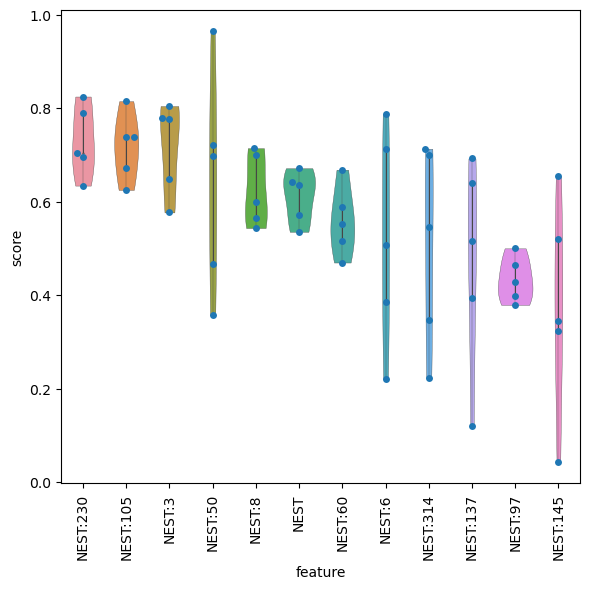

In [4]:
#Get assemblies with top predictive performance
conf_pred = 0.2
tmp = pd.read_csv('../data/predict_each_assembly_predictions.txt', sep='\t')
col_list = [col for col in tmp.columns if 'combined_%s'%conf_pred in col]
tmp = pd.DataFrame(data=tmp, columns=col_list)
tmp = tmp.rename(columns=dict(zip(list(tmp.columns), [col.split('_')[0] for col in tmp.columns])))
tmp2 = pd.DataFrame({'feature':tmp.columns, 'score':tmp.mean().values})
tmp2 = pd.merge(tmp2, anames, on='feature')
tmp2 = tmp2.sort_values(by='score', ascending=False); tmp2 = tmp2.reset_index(drop=True)


tmp3 = defaultdict(list)
for col in tmp.columns:
    for value in tmp[col].astype(float).tolist():
        tmp3['feature'].append(col)
        tmp3['score'].append(value)
tmp3 = pd.DataFrame(tmp3)
tmp3 = pd.merge(tmp3, anames, on='feature')

asmb_list = tmp2.loc[tmp2['score']>0.6,:]['feature'].tolist()

#visualize
plt.figure(figsize=(6,6))
sns.violinplot(data=tmp3, x='feature', y='score', order=tmp2['feature'].tolist(), cut=0, linewidth=0.25)
sns.swarmplot(data=tmp3, x='feature', y='score', order=tmp2['feature'].tolist())#, cut=0, linewidth=0.5)
plt.xticks(np.arange(0, tmp2.shape[0]), tmp2['feature'].tolist(), rotation=90)
plt.tight_layout()
plt.show()
plt.close()


In [5]:
#Get the SHAP values of top 10 important assemblies
amb_list = ['NEST:105', 'NEST:137', 'NEST:145', 'NEST:230', 'NEST:3', 'NEST:314', 'NEST:50', 'NEST:6', 'NEST:60', 'NEST:77', 'NEST:8', 'NEST:97']
amb_effect = ['resistant', 'resistant', 'resistant', 'resistant', 'sensitive', 'resistant', 'sensitive', 'sensitive', 'sensitive', 'sensitive', 'sensitive', 'sensitive']
amb_effect_dict = dict(zip(amb_list, amb_effect))

amb_list = list(set(amb_list) & set(asmb_list))

amb_shap = pd.read_csv('../data/SHAP_values_AMB.txt',delimiter = '\t', index_col = 0 , skiprows = [1])
amb_shap = amb_shap.loc[amb_list, :]
avg_abs_shap = amb_shap.abs().mean(axis = 1)
amb_shap.insert(0, 'avg_abs_shap', avg_abs_shap)
amb_shap.sort_values('avg_abs_shap', ascending = False, inplace = True)
amb_shap.insert(1, 'effect', [amb_effect_dict[asmb] for asmb in amb_shap.index])
amb_shap

,avg_abs_shap,effect,TCGA-18-3406,TCGA-18-3407,TCGA-18-3416,TCGA-18-4083,TCGA-22-5472,TCGA-43-5668,TCGA-43-7657,TCGA-43-7658,...,TCGA-NJ-A55O,TCGA-NK-A5CT,TCGA-NK-A5CX,TCGA-O2-A52S,TCGA-O2-A52W,TCGA-50-5944,TCGA-91-6829,TCGA-97-8176,TCGA-97-8547,TCGA-O2-A52Q
feature,,,,,,,,,,,,,,,,,,,,,
NEST:3,0.499461,sensitive,0.227881,0.472092,0.242241,0.259654,0.273840,-0.807548,0.345841,0.375522,...,0.259626,0.268326,0.443008,0.316441,0.271796,0.321084,-1.578587,0.288813,0.346054,-1.733151
NEST:50,0.206159,sensitive,0.147189,0.110910,0.105903,0.121451,0.129034,-0.416328,0.132407,0.150072,...,0.117306,0.123867,0.151279,0.130815,0.144756,0.149041,0.103541,0.111244,0.130935,0.125907
NEST:8,0.194997,sensitive,0.126812,0.130596,0.095766,0.160160,0.130873,-0.183514,0.104493,0.151485,...,0.129665,0.122234,0.101956,-0.272728,0.113709,0.093260,-0.348825,0.178058,0.062116,0.167393
NEST:230,0.152282,resistant,-0.102770,0.231224,-0.094283,-0.108449,-0.094576,-0.081062,-0.122738,-0.105581,...,-0.180903,-0.099972,-0.115934,0.224325,-0.117378,-0.135338,-0.095291,0.353044,-0.149204,0.213006
NEST:105,0.105493,resistant,0.386404,-0.084155,-0.053470,0.300583,-0.073993,-0.030728,-0.085133,-0.077048,...,0.367908,-0.064522,-0.090864,0.228021,-0.068467,-0.082664,-0.043127,-0.070220,-0.080988,-0.039953


In [6]:
sdf = pd.read_csv('../data/SHAP_values_exp_img.txt', delimiter = '\t', index_col = 0)
avg_abs_shap = sdf.abs().mean(axis = 1)
sdf.insert(0, 'avg_abs_shap', avg_abs_shap)
sdf.sort_values(by='avg_abs_shap', ascending=False)

,avg_abs_shap,TCGA-18-3406,TCGA-18-3407,TCGA-18-3416,TCGA-18-4083,TCGA-22-5472,TCGA-43-5668,TCGA-43-7657,TCGA-43-7658,TCGA-4B-A93V,...,TCGA-NJ-A55O,TCGA-NK-A5CT,TCGA-NK-A5CX,TCGA-O2-A52S,TCGA-O2-A52W,TCGA-50-5944,TCGA-91-6829,TCGA-97-8176,TCGA-97-8547,TCGA-O2-A52Q
feature,,,,,,,,,,,,,,,,,,,,,
base_value,0.360000,0.360000,3.600000e-01,0.360000,0.360000,0.360000,0.360000,0.360000,0.360000,0.360000,...,0.360000,0.360000,0.360000,0.360000,0.360000,3.600000e-01,0.360000,0.360000,0.360000,0.360000
T Cells CD8,0.070547,-0.012222,2.111111e-02,-0.024444,0.013333,-0.078889,0.107778,-0.123333,-0.067778,-0.061111,...,-0.075556,-0.010000,-0.028889,-0.088889,-0.003333,-1.033333e-01,0.068889,-0.097778,-0.121111,-0.025556
T Cells CD4 Memory Activated,0.052012,-0.032222,1.777778e-02,0.022222,-0.011111,-0.014444,0.155556,-0.042222,-0.042222,-0.012222,...,-0.043333,-0.045556,-0.041111,-0.067778,-0.073333,-4.111111e-02,-0.065556,-0.053333,-0.025556,-0.034444
Macrophages M1,0.050704,0.002222,8.888889e-03,0.004444,-0.025556,-0.044444,0.038889,-0.027778,-0.001111,-0.102222,...,-0.078889,-0.058889,0.001111,0.003333,-0.006667,-1.522222e-01,-0.116667,-0.051111,-0.077778,0.010000
TMB_pos,0.038597,-0.055556,-1.333333e-02,-0.024444,-0.005556,-0.025556,-0.003333,-0.008889,-0.001111,-0.010000,...,-0.003333,0.001111,-0.032222,0.016667,-0.018889,3.333333e-03,0.110000,-0.026667,-0.022222,-0.041111
Angiogenesis,0.037247,-0.015556,-2.777778e-02,-0.016667,-0.002222,-0.017778,0.133333,-0.020000,-0.008889,-0.001111,...,-0.035556,-0.006667,0.006667,-0.038889,-0.006667,-3.000000e-02,0.025556,-0.026667,-0.021111,-0.055556
IDS,0.033718,-0.048889,-1.555556e-02,-0.091111,-0.046667,-0.014444,0.065556,-0.050000,-0.040000,-0.015556,...,-0.034444,-0.027778,-0.002222,-0.024444,-0.035556,3.083953e-18,0.127778,-0.004444,-0.005556,-0.017778
tertiary_lymphoid_structure,0.031218,-0.045556,-1.888889e-02,-0.040000,-0.003333,0.000000,0.017778,0.016667,-0.028889,0.010000,...,-0.003333,-0.027778,-0.014444,-0.012222,-0.024444,8.888889e-03,0.044444,-0.007778,0.001111,-0.026667
tumor_proliferation_rate,0.027435,-0.043333,-4.666667e-02,-0.006667,-0.008889,-0.043333,0.006667,-0.023333,0.010000,-0.034444,...,-0.014444,-0.002222,-0.015556,-0.001111,-0.002222,-1.333333e-02,0.013333,-0.014444,-0.023333,-0.026667


In [7]:
#These features were chosen based on model_res (they are the top features from predicting imputed response)
keeprows = ['T Cells CD8','T Cells CD4 Memory Activated', 'Macrophages M1', 'Angiogenesis', 'IES']


feature_dir_dict = {'T Cells CD8': 1, 'T Cells CD4 Memory Activated': 1, 'Macrophages M1': 1, 'TMB_pos':1, 'MHCII': 1,
               'Angiogenesis': -1, 'protumor_cytokines':-1, 'IES': -1, 'T Cells Regulatory Tregs':-1 , 'Tumor_associated_macrophages':-1}


In [8]:
#@@@#Use image and expression features to predict AMB-model imputed response
model_res = pd.read_csv('../data/SHAP_values_exp_img.txt', delimiter = '\t', index_col = 0)
model_res = model_res[model_res.index.isin(keeprows)]

avg_abs_shap = model_res.abs().mean(axis = 1)
feat_dir = model_res.index.map(feature_dir_dict)

model_res.insert(0, 'avg_abs_shap', avg_abs_shap)
model_res.insert(1, 'feature_effect',feat_dir)

model_res.sort_values('avg_abs_shap', ascending = False, inplace = True)

norm_model_res = model_res
norm_model_res['avg_abs_shap'] = model_res['avg_abs_shap'].div(model_res['avg_abs_shap'].sum(axis=0))
norm_model_res['weighted_effect'] = [norm_model_res['avg_abs_shap'].tolist()[i] * norm_model_res['feature_effect'].tolist()[i] for i in range(norm_model_res.shape[0])]
norm_model_res = pd.DataFrame(data=norm_model_res, columns=['avg_abs_shap', 'feature_effect', 'weighted_effect'])
norm_model_res 

,avg_abs_shap,feature_effect,weighted_effect
feature,,,
T Cells CD8,0.299878,1,0.299878
T Cells CD4 Memory Activated,0.221089,1,0.221089
Macrophages M1,0.215531,1,0.215531
Angiogenesis,0.158330,-1,-0.158330
IES,0.105172,-1,-0.105172


In [9]:
feature_dir_dict2 = {'NEST:3':
                    {'T Cells CD8': 1, 'T Cells CD4 Memory Activated': 1, 'Macrophages M1': 1, 'TMB_pos':-1, 'MHCII': 1,
                     'Angiogenesis': -1, 'protumor_cytokines':-1, 'IES': 1, 'T Cells Regulatory Tregs':-1, 'Tumor_associated_macrophages':1},
                    'NEST:50':
                    {'T Cells CD8': 1, 'T Cells CD4 Memory Activated': 1, 'Macrophages M1': 1, 'TMB_pos':-1, 'MHCII': -1,
                     'Angiogenesis': -1, 'protumor_cytokines':-1, 'IES': 1, 'T Cells Regulatory Tregs':1, 'Tumor_associated_macrophages':-1},
                    'NEST:8':
                    {'T Cells CD8': 1, 'T Cells CD4 Memory Activated': 1, 'Macrophages M1': 1, 'TMB_pos':1, 'MHCII': -1,
                     'Angiogenesis': -1, 'protumor_cytokines':-1, 'IES': -1, 'T Cells Regulatory Tregs':-1, 'Tumor_associated_macrophages':-1},
                    'NEST:230':
                    {'T Cells CD8': 1, 'T Cells CD4 Memory Activated': 1, 'Macrophages M1': 1, 'TMB_pos':1, 'MHCII': -1,
                     'Angiogenesis': -1, 'protumor_cytokines':-1, 'IES': 1, 'T Cells Regulatory Tregs':-1, 'Tumor_associated_macrophages':-1},
                    'NEST:105':
                    {'T Cells CD8': 1, 'T Cells CD4 Memory Activated': 1, 'Macrophages M1': -1, 'TMB_pos':1, 'MHCII': -1,
                     'Angiogenesis': 1, 'protumor_cytokines':-1, 'IES': -1, 'T Cells Regulatory Tregs':1, 'Tumor_associated_macrophages':-1}}
                    

                    

In [10]:
amb_final_ls = amb_shap.index.tolist()

Avg_shap = []
for amb in amb_final_ls:
    res = pd.read_csv('../data/SHAP_assemblies/SHAP_values_%s.txt'%(amb), delimiter = '\t', index_col = 0)
    avg_abs_shap = res.abs().mean(axis = 1)
    Avg_shap.append(avg_abs_shap)

RES = pd.concat(Avg_shap, axis = 1)
RES.columns = [amb for amb in amb_final_ls]
RES = RES[RES.index.isin(keeprows)]
norm_RES = RES.div(RES.sum(axis = 0))

norm_RES = norm_RES[norm_RES.index.isin(keeprows)]
norm_RES

,NEST:3,NEST:50,NEST:8,NEST:230,NEST:105
feature,,,,,
IES,0.136349,0.112290,0.139915,0.266732,0.189795
T Cells CD8,0.192702,0.290664,0.201637,0.189829,0.330114
Macrophages M1,0.174168,0.068804,0.215733,0.161770,0.224707
T Cells CD4 Memory Activated,0.217183,0.184004,0.259943,0.080037,0.083561
Angiogenesis,0.279598,0.344239,0.182772,0.301633,0.171823


In [11]:
RES

,NEST:3,NEST:50,NEST:8,NEST:230,NEST:105
feature,,,,,
IES,0.013252,0.011585,0.016543,0.026033,0.010311
T Cells CD8,0.018729,0.029989,0.023841,0.018527,0.017935
Macrophages M1,0.016928,0.007099,0.025508,0.015788,0.012208
T Cells CD4 Memory Activated,0.021108,0.018984,0.030735,0.007811,0.004540
Angiogenesis,0.027175,0.035516,0.021611,0.029439,0.009335


In [12]:
## gene2assembly
assemblies = norm_RES.columns.tolist()
immunogenic_features = norm_RES.index.tolist()

# load mutational frequency
fdf = pd.read_csv('../data/Samstein_gene_mut_freq.txt', sep='\t')

# load gene-assembly
hdf = pd.read_csv('../data/NeST/NeST_node.csv')

# top N genes per assembly
gene2assembly = defaultdict(list)
genes = []
for asmb in assemblies:
    geneList = hdf.loc[hdf['name']==asmb,:]['Genes'].tolist()[0].split(' ')
    geneList = sorted(list(set(geneList) & set(fdf['gene'].tolist())))
    geneList = fdf.loc[fdf['gene'].isin(geneList),:].sort_values(by='freq', ascending=False)['gene'].tolist()[:3]
    genes = sorted(list(set(genes).union(set(geneList))))
gene2assembly['feature']=genes
for asmb in assemblies:
    tmp = []
    for gene in genes:
        if gene in hdf.loc[hdf['name']==asmb,:]['Genes'].tolist()[0].split(' '):
            tmp.append(.1)
        else: tmp.append(0)
    gene2assembly[asmb] = tmp
gene2assembly = pd.DataFrame(gene2assembly)
gene2assembly = gene2assembly.set_index('feature')
norm_g2a = gene2assembly.div(gene2assembly.sum(axis = 0))

In [13]:
feature_list = list(np.append(np.append(genes, assemblies), immunogenic_features))
feature_list = list(np.append(feature_list, ['ICI response']))


source, target, values = [], [], []
colors = []
x, y = [], []

for i, exp_list in enumerate([genes, assemblies, immunogenic_features, ['ICI_response']]):
    x_loc = 0.2 * i + 0.2
    x = np.append(x, [x_loc]*len(exp_list))
    for j, exp in enumerate(exp_list):
        y.append((0.5+j)/len(exp_list))


# from gene2assembly
for col in norm_g2a.columns:
    for i in range(norm_g2a.shape[0]):
        feature, value = norm_g2a.index[i], gene2assembly[col].tolist()[i]
        if value == 0: continue
        source.append(feature_list.index(col))
        target.append(feature_list.index(feature))
        values.append(value)
        colors.append('grey')
        
# from assembly2immunogenic features
for col in norm_RES.columns:
    for i in range(norm_RES.shape[0]):
        feature, value = norm_RES.index[i], norm_RES[col].tolist()[i]
        if value <= 0.2: continue
        source.append(feature_list.index(col))
        target.append(feature_list.index(feature))
        values.append(value)
        colors.append(feature_dir_dict2[col][feature])
        
# from immunogenic features2response
for j in range(norm_model_res.shape[0]):
    feature, value, feature_effect = norm_model_res.index[j], norm_model_res['avg_abs_shap'].astype(float).tolist()[j], norm_model_res['feature_effect'].astype(float).tolist()[j]
    source.append(feature_list.index(feature))
    target.append(feature_list.index('ICI response'))
    values.append(value)
    colors.append(feature_effect)
    
    

In [14]:
import plotly.express as px
colors2 = ['lightcoral' if color == 1 else 'skyblue' for color in colors]
fig = go.Figure(data=[go.Sankey(
    node = dict(
        pad = 15, 
        thickness = 20, 
        line = dict(color = 'black', width = 0.5),
        label = feature_list,
        x=x,
        y=y,
        color = 'black'),
    
    link = dict(
        source = source,
        target = target,
        value = values,
        color = colors2)
    )])


# display 
fig.show(renderer='iframe')